In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model  # Import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, concatenate  # Import concatenate
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')

# Load your dataset
real_users = pd.read_csv("users.csv")
fake_users = pd.read_csv("fusers.csv")

# Combine the two datasets
data = pd.concat([real_users, fake_users], ignore_index=True)

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Text preprocessing: lowercasing, stop word removal, and stemming
data['description'] = data['description'].astype(str).apply(lambda x: x.lower())  # Convert to lowercase
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
data['description'] = data['description'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() if word not in stop_words]))

# Tokenization
max_words = 10000  # Set the maximum number of words in your vocabulary
max_sequence_length = 100  # Set the maximum sequence length for descriptions

# Tokenization
sequences = data['description'].apply(lambda x: x.split())  # Tokenize by splitting
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(sequences)
sequences = tokenizer.texts_to_sequences(sequences)
X_text = pad_sequences(sequences, maxlen=max_sequence_length)

# Other numerical features
numerical_features = ['statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count']
X_numerical = data[numerical_features].values

# Create labels (1 for real users, 0 for fake users)
y = np.array([1] * len(real_users) + [0] * len(fake_users))

# Split the data into training and testing sets
X_train_text, X_test_text, X_train_numerical, X_test_numerical, y_train, y_test = train_test_split(
    X_text, X_numerical, y, test_size=0.2, random_state=42
)

# Define the LSTM model for text data
text_model = Sequential()
text_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
text_model.add(LSTM(128))

# Define a separate input layer for numerical data
numerical_input = Sequential()
numerical_input.add(Dense(64, input_dim=X_train_numerical.shape[1]))

# Concatenate the outputs from both models
combined_input = concatenate([text_model.output, numerical_input.output])
output = Dense(1, activation='sigmoid')(combined_input)

# Create the final model
model = Model(inputs=[text_model.input, numerical_input.input], outputs=output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

# Train the model
model.fit([X_train_text, X_train_numerical], y_train, epochs=25, batch_size=64, validation_data=([X_test_text, X_test_numerical], y_test))

Epoch 1/25
36/36 [==============================] - 10s 202ms/step - loss: 12.4604 - accuracy: 0.4871 - val_loss: 3.5179 - val_accuracy: 0.4663
Epoch 2/25
36/36 [==============================] - 4s 113ms/step - loss: 8.1938 - accuracy: 0.5209 - val_loss: 2.8100 - val_accuracy: 0.4858
Epoch 3/25
36/36 [==============================] - 3s 89ms/step - loss: 4.4285 - accuracy: 0.6003 - val_loss: 1.3021 - val_accuracy: 0.5567
Epoch 4/25
36/36 [==============================] - 5s 130ms/step - loss: 11.0312 - accuracy: 0.6398 - val_loss: 6.4932 - val_accuracy: 0.5106
Epoch 5/25
36/36 [==============================] - 2s 69ms/step - loss: 12.8992 - accuracy: 0.7387 - val_loss: 6.8552 - val_accuracy: 0.4965
Epoch 6/25
36/36 [==============================] - 2s 56ms/step - loss: 9.9742 - accuracy: 0.8194 - val_loss: 6.2845 - val_accuracy: 0.4911
Epoch 7/25
36/36 [==============================] - 2s 57ms/step - loss: 8.6633 - accuracy: 0.8305 - val_loss: 5.0114 - val_accuracy: 0.5213
Epoch 

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test data
y_pred = (model.predict([X_test[:, :max_sequence_length], X_test[:, max_sequence_length:]]) > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision * 100:.2f}%")

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall * 100:.2f}%")

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1 * 100:.2f}%")


18/18 [==============================] - 1s 8ms/step
Accuracy: 69.68%
Precision: 74.55%
Recall: 67.53%
F1-Score: 70.87%


18/18 [==============================] - 0s 7ms/step


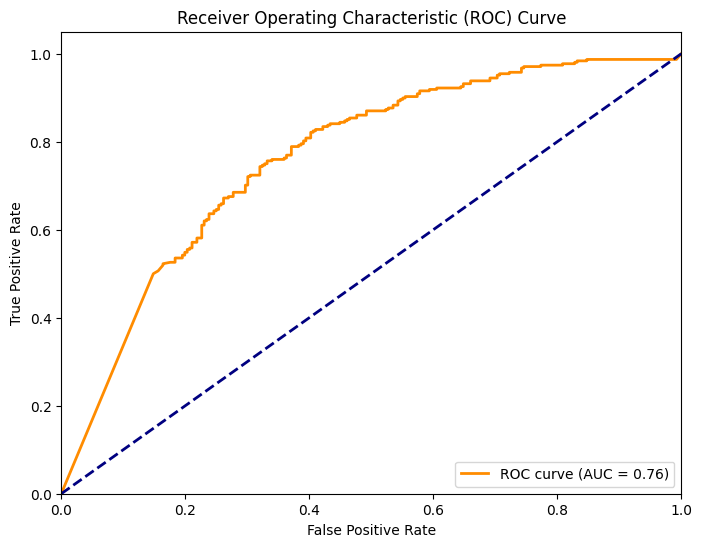

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the predicted probabilities
y_probs = model.predict([X_test[:, :max_sequence_length], X_test[:, max_sequence_length:]])

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
